# Building a Basic Content-Based Filtering Recommendation System Model for MyShoplivery E-commerce Platform

I developed this simple content based recommendation system for MyShoplivery, an e-commerce shopping platform in Nigeria. This recommendation system is able to suggest similar items based on item metadata, such as description, categories, and tags. The general idea behind these recommender system is that if a custumer selects a particular item, he or she will also like an item that is similar to it. And to recommend this with MyShoplivery App, you can walk into stores from your mobile phone, select items, pay and watch them delivered to your doorsteps in minutes.

This project helps to find building content-based recommendation system without fear of complexity of getting started with building one and that even gives a better result while it is subject to further advanced improvement subject to industry standard in terms quality, or accuracy.


Personalization of the user experience has been a high priority and has become the new mantra in the consumer-focused industry. You might have observed e-commerce companies casting personalized ads for you suggesting what to buy, which news to read, which video to watch, where/what to eat, and who you might be interested in networking (friends/professionals) on social media sites. Recommender systems are the core information filtering system designed to predict the user preference and help to recommend correct items to create a user-specific personalization experience. There are two types of recommendation systems: 1) content-based filtering and 2) collaborative filtering.

Before I perform any of the above steps, let's import the necessary libraries that will be helping in buiding the recommmendation model.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #Import TfIdfVectorizer from scikit-learn
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

Next thing  is to load the dataset I used into a pandas DataFrame, in this case, MyShoplivery metadata dataset:

In [2]:
# Load Movies Metadata
myshoplivery_data = pd.read_csv('myshoplivery_data1 - Sheet2.csv', low_memory=False)
#Print the first three rows
myshoplivery_data.head(5)

,Id,TITLE,DESCRIPTION,Categories,Tags,Weight,Images,Price,Unnamed: 8
0,11616,HIVE FIVE HONEY 227G,Hive Five is Bax Bees’ premium product contain...,"Groceries , Food Cupboard",Condiments & Salad Dressing | Food Cupboard | ...,0.227,https://www.picclickimg.com/d/l400/pict/224019...,1200,NaN
1,11581,CHI HAPPY HOUR ORANGE SAFARI 1LTR,Happy hour Orange Safari is a rare blend of na...,"Groceries , Beverages",Beverages | Drinks,1,http://oldenglishsuperstores.com/image/cache/c...,400,NaN
2,11574,REXONA SEXY BOUQUET SPRAY 200ML,"The best accessory, No white marks.","Health & Beauty , Personal Care",Beauty & Personal Care | Personal Care,0.2,https://tellme.ng/wp-content/uploads/2020/10/1...,1200,NaN
3,11565,FEFFERETTI CUBED CHINCHIN COCONUT 70G,NaN,"Groceries , Snacks",Snacks | Cooking & Baking,0.07,NaN,100,NaN
4,11564,FEFFERETTI CUBED CHINCHIN VANILLA 70G,NaN,"Groceries , Snacks",Snacks | Cooking & Baking,0.07,NaN,100,NaN


# Data EDA

Item description — Word count distribution
Let's look at the distribution of top part-of-speech tags in the items descriptions

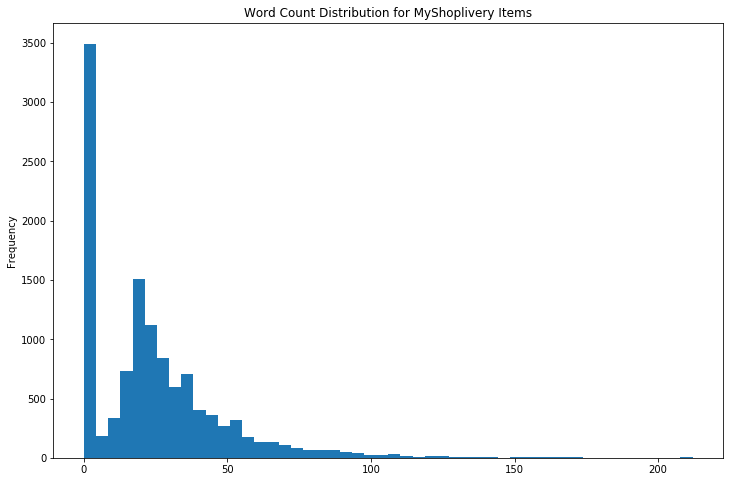

In [3]:
# Calculating the word count for item description
myshoplivery_data['word_count'] = myshoplivery_data['DESCRIPTION'].apply(lambda x: len(str(x).split()))# Plotting the word count
myshoplivery_data['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for MyShoplivery Items')

We don’t have many lengthy product description. It is clear that myshoplivery dataset used provides short descriptions and some with no descriptions.

**Let´s check the NA's ,the percentage of null values by plotting them**

C:\Users\Public\DSNanaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


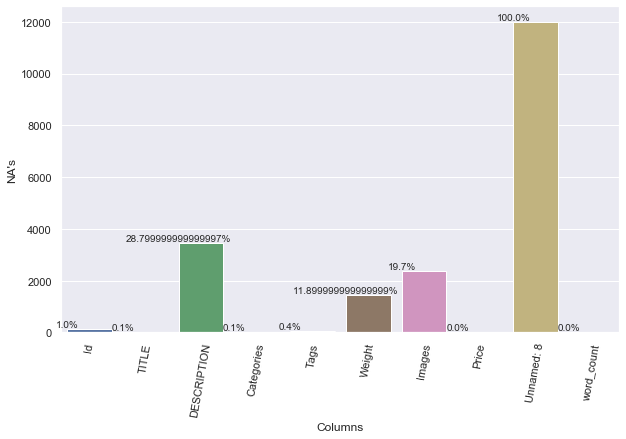

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = myshoplivery_data.columns
y = myshoplivery_data.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/myshoplivery_data.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)

plt.show()

**Let's carry out some data cleaning process to avoid discrepancies**

In this step I will convert the text and keyword instances into lowercase and strip all the spaces between them. 

Removing the spaces between words is an important preprocessing step. It is done so that your vectorizer doesn't count item such as: "Beauty Cream" and "Beauty Soap" as the same. 
After this processing step, the afore mentioned items will be represented as "beautycream" and "beautysoap" and will be distinct to the vectorizer. 

In [5]:
myshoplivery_data['DESCRIPTION'] = myshoplivery_data['DESCRIPTION'].dropna(axis=0)

In [6]:
#Replace NaN with an empty string
myshoplivery_data['Categories'] = myshoplivery_data['Categories'].fillna('none')
myshoplivery_data['TITLE'] = myshoplivery_data['TITLE'].fillna('none')
myshoplivery_data['Images'] = myshoplivery_data['Images'].fillna('https://www.freegreatpicture.com/files/198/211-blank-shopping-bags.jpg')
#Replace NaN with an empty string


In [7]:
#drop unnecessary column that I won't be using
myshoplivery_data= myshoplivery_data.drop(['Weight','Price','Unnamed: 8'],axis=1)

In [8]:
#Cleaning the the category and tags column
def clean_data(x):
        if isinstance(x, list): 
            return [str.lower(i.replace("|", ",")) for i in x]             
        else: 
            #Check if director exists. If not, return empty string          
            if isinstance(x, str):
                return str.lower(x.replace(">", ","))          
            else:           
                return '' 
# Apply clean_data function to your features.  
features = ['DESCRIPTION','Categories', 'Tags']
for feature in features:
    myshoplivery_data[feature] = myshoplivery_data[feature].apply(clean_data)

            
# Function for removing NonAscii characters in the description column
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()


# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
myshoplivery_data['DESCRIPTION'] = myshoplivery_data['DESCRIPTION'].apply(_removeNonAscii)
myshoplivery_data['DESCRIPTION'] = myshoplivery_data['DESCRIPTION'].apply(func = make_lower_case)
myshoplivery_data['DESCRIPTION'] = myshoplivery_data['DESCRIPTION'].apply(func=remove_punctuation)
myshoplivery_data['DESCRIPTION'] = myshoplivery_data['DESCRIPTION'].apply(func=remove_html)

myshoplivery_data['Categories'] = myshoplivery_data['Categories'].apply(_removeNonAscii)
myshoplivery_data['Categories'] = myshoplivery_data['Categories'].apply(func = make_lower_case)
myshoplivery_data['Categories'] = myshoplivery_data['Categories'].apply(func=remove_punctuation)
myshoplivery_data['Categories'] = myshoplivery_data['Categories'].apply(func=remove_html)

myshoplivery_data['Tags'] = myshoplivery_data['Tags'].apply(_removeNonAscii)
myshoplivery_data['Tags'] = myshoplivery_data['Tags'].apply(func = make_lower_case)
myshoplivery_data['Tags'] = myshoplivery_data['Tags'].apply(func=remove_punctuation)
myshoplivery_data['Tags'] = myshoplivery_data['Tags'].apply(func=remove_html)


myshoplivery_data.dropna()

,Id,TITLE,DESCRIPTION,Categories,Tags,Images,word_count
0,11616,HIVE FIVE HONEY 227G,hive five is bax bees premium product containi...,groceries food cupboard,condiments salad dressing food cupboard cookin...,https://www.picclickimg.com/d/l400/pict/224019...,16
1,11581,CHI HAPPY HOUR ORANGE SAFARI 1LTR,happy hour orange safari is a rare blend of na...,groceries beverages,beverages drinks,http://oldenglishsuperstores.com/image/cache/c...,15
2,11574,REXONA SEXY BOUQUET SPRAY 200ML,the best accessory no white marks,health beauty personal care,beauty personal care personal care,https://tellme.ng/wp-content/uploads/2020/10/1...,6
3,11565,FEFFERETTI CUBED CHINCHIN COCONUT 70G,,groceries snacks,snacks cooking baking,https://www.freegreatpicture.com/files/198/211...,1
4,11564,FEFFERETTI CUBED CHINCHIN VANILLA 70G,,groceries snacks,snacks cooking baking,https://www.freegreatpicture.com/files/198/211...,1
...,...,...,...,...,...,...,...
11991,9.78E+12,THE 4-HOUR WORK WEEK,,home office books stationeries,book,https://www.freegreatpicture.com/files/198/211...,1
11992,9.78E+12,HOW TO BE A LADY- SAMSONS-GILE,,home office books stationeries,book samsons gile,https://www.freegreatpicture.com/files/198/211...,1
11994,311102141,GREAT BRITISH KIDS WRIST WATCH,,baby products apparel accessories,wristwatch kids,https://www.freegreatpicture.com/files/198/211...,1
11995,7.20E+11,EXPRESSIONS CARD WITH THANKS,,home office books stationeries,card,https://www.freegreatpicture.com/files/198/211...,1


**Let's now see the plot of the filled null values**

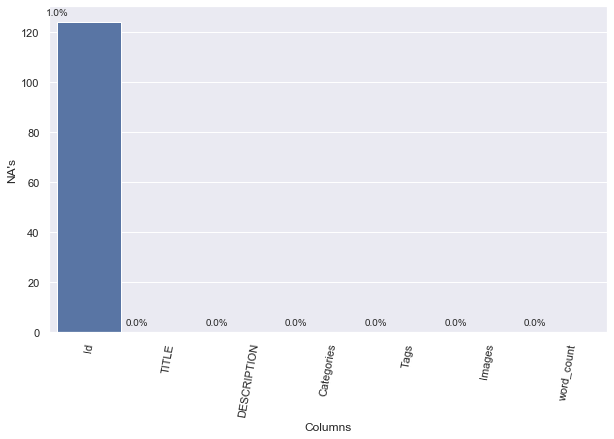

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = myshoplivery_data.columns
y = myshoplivery_data.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/myshoplivery_data.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)

plt.show()

**Let's have a look at the description column**

In [10]:
#Print plot overviews of the first 5 movies.
myshoplivery_data['DESCRIPTION'].head()

0    hive five is bax bees premium product containi...
1    happy hour orange safari is a rare blend of na...
2                    the best accessory no white marks
3                                                     
4                                                     
Name: DESCRIPTION, dtype: object

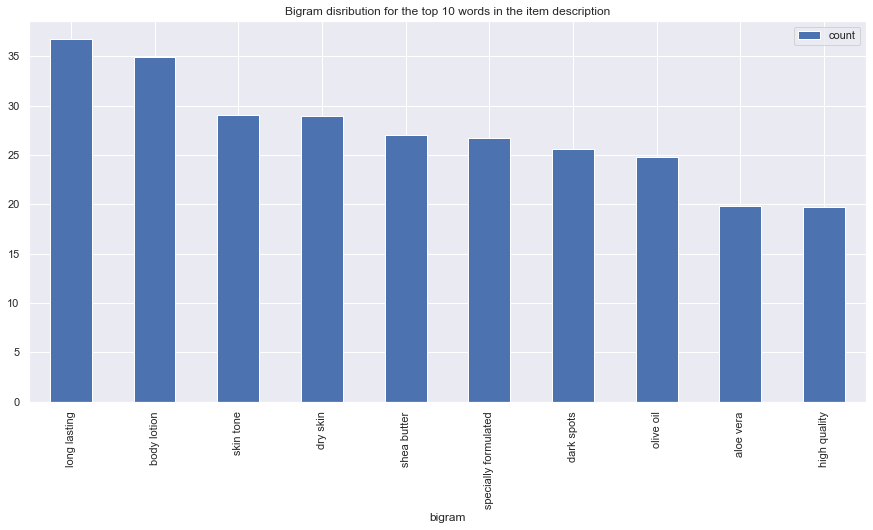

In [11]:
#Converting text descriptions into vectors using TF-IDF using Bigram or Trigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(myshoplivery_data['DESCRIPTION'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
#trigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True)
#trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 10 records
bigram = bigram.head(10)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 10 words in the item description", figsize = (15,7), )

In [12]:
myshoplivery_data.head()

,Id,TITLE,DESCRIPTION,Categories,Tags,Images,word_count
0,11616,HIVE FIVE HONEY 227G,hive five is bax bees premium product containi...,groceries food cupboard,condiments salad dressing food cupboard cookin...,https://www.picclickimg.com/d/l400/pict/224019...,16
1,11581,CHI HAPPY HOUR ORANGE SAFARI 1LTR,happy hour orange safari is a rare blend of na...,groceries beverages,beverages drinks,http://oldenglishsuperstores.com/image/cache/c...,15
2,11574,REXONA SEXY BOUQUET SPRAY 200ML,the best accessory no white marks,health beauty personal care,beauty personal care personal care,https://tellme.ng/wp-content/uploads/2020/10/1...,6
3,11565,FEFFERETTI CUBED CHINCHIN COCONUT 70G,,groceries snacks,snacks cooking baking,https://www.freegreatpicture.com/files/198/211...,1
4,11564,FEFFERETTI CUBED CHINCHIN VANILLA 70G,,groceries snacks,snacks cooking baking,https://www.freegreatpicture.com/files/198/211...,1


In [13]:
myshoplivery_data['item_name'] = myshoplivery_data['TITLE']

In [14]:
myshoplivery_data['item_name'] = myshoplivery_data['item_name'].apply(_removeNonAscii)
myshoplivery_data['item_name'] = myshoplivery_data['item_name'].apply(func = make_lower_case)
myshoplivery_data['item_name'] = myshoplivery_data['item_name'].apply(func=remove_punctuation)
myshoplivery_data['item_name'] = myshoplivery_data['item_name'].apply(func=remove_html)

In [15]:
myshoplivery_data["text"]=  myshoplivery_data['DESCRIPTION'] + ' '+ myshoplivery_data['item_name'] + ' ' + myshoplivery_data['Categories'] + ' ' + myshoplivery_data['Tags']
df_shop= myshoplivery_data[['Id','TITLE','text']]
df_shop.head()

,Id,TITLE,text
0,11616,HIVE FIVE HONEY 227G,hive five is bax bees premium product containi...
1,11581,CHI HAPPY HOUR ORANGE SAFARI 1LTR,happy hour orange safari is a rare blend of na...
2,11574,REXONA SEXY BOUQUET SPRAY 200ML,the best accessory no white marks rexona sexy ...
3,11565,FEFFERETTI CUBED CHINCHIN COCONUT 70G,fefferetti cubed chinchin coconut 70g groceri...
4,11564,FEFFERETTI CUBED CHINCHIN VANILLA 70G,fefferetti cubed chinchin vanilla 70g groceri...


# Model Building Using TF-IDF 
Term Frequency-Inverse Document Frequency (TF-IDF) vectors

Let's compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before. 

In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score. 
scikit-learn gives a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.
- Import the Tfidf module using scikit-learn;
- Remove stop words like 'the', 'an', etc. since they do not give any useful information about the topic;</ui>
- Replace not-a-number values with a blank string; </ui>
- Finally, construct the TF-IDF matrix on the data.</ui>

In [16]:
#Converting text descriptions into vectors using TF-IDF
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df_shop['text'])
total_words = tfidf_matrix.sum(axis=0) 
total_words

matrix([[0.40724233, 1.11370983, 0.14040114, ..., 0.1521251 , 0.16150942,
         0.16150942]])

In [17]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_shop['text'])
#Output the shape of tfidf_matrix
tfidf_matrix.shape

(11997, 17837)

From the above output, there are 14031 vocabularies in the metadata.

In [18]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel
#Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[1]

array([0.00354695, 1.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [19]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[10000:10500]

['ls',
 'lt',
 'ltr',
 'ltra',
 'ltrs',
 'lts',
 'lu',
 'lube',
 'lubrastrip',
 'lubrica',
 'lubricant',
 'lubricants',
 'lubricate',
 'lubricated',
 'lubricates',
 'lubricating',
 'lubrication',
 'lucas',
 'lucidum',
 'luck',
 'lucky',
 'lucozade',
 'lucrative',
 'lucy',
 'luff',
 'luffa',
 'luggage',
 'lukewarm',
 'lulu',
 'lumen',
 'luminaire',
 'lumine',
 'luminessence',
 'luminosity',
 'luminous',
 'lumiskin',
 'lumoinous',
 'luna',
 'lunch',
 'lunchbox',
 'lunchboxes',
 'lunches',
 'lunchtime',
 'lundary',
 'lune',
 'lungs',
 'lunshbox',
 'luodais',
 'lures',
 'luscious',
 'lusciously',
 'lush',
 'lust',
 'luster',
 'lustre',
 'lustrehair',
 'lustrous',
 'lustrously',
 'lutein',
 'luther',
 'luvable',
 'lux',
 'luxe',
 'luxuriant',
 'luxuries',
 'luxurious',
 'luxuriously',
 'luxury',
 'lychee',
 'lycopene',
 'lye',
 'lyn',
 'lynda',
 'lynx',
 'lyons',
 'lysol',
 'm2',
 'ma',
 'mabelline',
 'mac',
 'macabeo',
 'macadamia',
 'macaroni',
 'macarthur',
 'maccaw',
 'maccoffee',
 'mac

Next, you will use the cosine_similarity to measure the distance between the embeddings.

In [20]:
cosine_sim.shape

(11997, 11997)

In [21]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(myshoplivery_data.index, index=df_shop['TITLE']).drop_duplicates()
indices[:10]

TITLE
HIVE FIVE HONEY 227G                       0
CHI HAPPY HOUR ORANGE SAFARI 1LTR          1
REXONA SEXY BOUQUET SPRAY 200ML            2
FEFFERETTI CUBED CHINCHIN COCONUT 70G      3
FEFFERETTI CUBED CHINCHIN VANILLA  70G     4
FEFFERETTI CUBED CHINCHIN NUTMEG 70G       5
FEFFERETTI CUBED CHINCHIN CINNAMON  70G    6
SOULMATE HAIR CONDITIONER PLUS 330G        7
MEGA GROWTH NON-LYN RELAXER 12S            8
GOOD KNIGHT POWER SHOTs 120ML              9
dtype: int64

I now have my dataset in good shape to buid a recommendation function. 

These are the steps:
- Get the index of the movie given its title.
- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position, and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Print out the item titles and corresponding images to the indices of the top elements.

In [22]:
# Function that takes in item title as input and outputs most similar products
def get_recommendations(TITLE,Tags, cosine_sim=cosine_sim):
    # Get the index of the items that matches the title
    idx = indices[TITLE]

    # Get the pairwsie similarity scores of all items
    sim_scores = list(enumerate(cosine_sim[idx])) # Sort the items
    #Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar items
    sim_scores = sim_scores[1:5]# Item indicies, Get the items indices
    shop_indices = [i[0] for i in sim_scores]
   
     
    # It reads the top 5 recommended Items titles and print the images
    print(df_shop['TITLE'].iloc[shop_indices])
    rec= df_shop[['TITLE','Images']].iloc[shop_indices] 
    
    for i in rec['Images']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img), )

In [23]:
#get_recommendations('REXONA SEXY BOUQUET SPRAY 200ML', 'Beauty & Personal Care')

# Model Improvement  with CountVectorizer()

The plot description based in the recommender is very important and that is why I will choose CountVectorizer() instead of TF-IDF. This is because I do not want to down-weight the categories, tags values of items. It doesn't make much intuitive sense to down-weight them in this context. The major difference between CountVectorizer() and TF-IDF is the inverse document frequency (IDF) component which is present in later and not in the former.

I need to extract some kind of features from the dataset by creating a text column before I can compute the similarity and/or dissimilarity between them. 
To put it simply, it is not possible to compute the similarity between any two overviews in their raw forms. To do this, I need to compute the word vectors of each overview or document, as it will be called from now on. As the name suggests, word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other. 

In [24]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_shop['text'])
count_matrix.shape

(11997, 17837)

From the above output, you can see that there are 14363 vocabularies in the dataset. Next, I will use the cosine_similarity to measure the distance between the embeddings.

In [25]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of your main DataFrame and construct reverse mapping as before
myshoplivery_data = myshoplivery_data.reset_index()
indices = pd.Series(myshoplivery_data.index, index=myshoplivery_data['TITLE'])

You can now reuse your get_recommendations() function by passing in the new cosine_sim2 matrix as your second or 3rd argument.

In [26]:
#get_recommendations('REXONA SEXY BOUQUET SPRAY 200ML', cosine_sim2)

# Model Evaluation

# Function to get the top-N recomendations order by score

In [27]:
def get_recommendation(top, myshoplivery_data, scores):
    recommendation = pd.DataFrame(columns = ['User Id','Item Id','TITLE','score'])
    count = 0
    for i in top:
        recommendation.at[count, 'User Id'] = u
        recommendation.at[count, 'Item Idhttp://localhost:8888/notebooks/AI%20%26%20ML%20PGP%20UNIVERSITY%20OF%20TEXAS/MyShoplivery_projects/MyShopLivery%20Recommendation%20system%20Model/Content-based%20Recommendation%20Model%20.ipynb#Let's-test-the-recommender-by-selecting-the-user-with-item-Id-11574'] = df_shop['Id'][i]
        recommendation.at[count, 'TITLE'] = df_shop['TITLE'][i]
        recommendation.at[count, 'score'] =  scores[count]
        count += 1
    return recommendation

# Let's test the recommender by selecting the user with item Id 11574

In [28]:
u = 2 #the user 2(using index)
user= myshoplivery_data[['Id','text']]
user_q = user.iloc[[u]]
user_q

,Id,text
2,11574,the best accessory no white marks rexona sexy ...


# Using TF-IDF

In [29]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def TF_IDF_recommender(user):
    #fitting and transforming the vector
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_itemid = tfidf_vectorizer.fit_transform(df_shop['text']) #fitting and transforming the vector
    user_tfidf = tfidf_vectorizer.transform(user_q['text'])
    cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_itemid)
    output = list(cos_similarity_tfidf)
    top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
    list_scores = [output[i][0][0] for i in top]
    return get_recommendation(top, myshoplivery_data, list_scores)

In [31]:
TF_IDF_recommender(user_q)

,User Id,Item Id,TITLE,score
0,2,11574,REXONA SEXY BOUQUET SPRAY 200ML,1
1,2,VAPORISATIEUR NATURAL,SPRAY,0.387165
2,2,3.61E+12,ADIDAS DRY POWER ANTI -WHITE MARKS SPRAY,0.375193
3,2,11356,STAY COOL BODY SPRAY 200ML,0.374342
4,2,8.71E+12,REXONA RADIANT SUNSHINE 200ML,0.353545
5,2,8.71E+12,REXONA INVISIBLE 200ML,0.331103
6,2,6.55E+13,MAKE ME WHITE ANTI MARKS CARROT -400ML,0.330489
7,2,2275,REXONA MEN PROTECTION ACTIVE 200ML,0.315657
8,2,11151,WONDER BODY SPRAY 250ML,0.309554
9,2,2194,REXONA BIORYTHM SPRAY 200ML,0.309202


We can see that the system has been able to find items with similar descriptions,but from the evaluation the quality of recommendations is not that great. 

# Using Count Vectorizer

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
def CVextor_recommender(user):
    count_vectorizer = CountVectorizer()
    count_item_id = count_vectorizer.fit_transform((df_shop['text'])) #fitting and transforming the vector
    user_count = count_vectorizer.transform(user_q['text'])
    cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_item_id)
    output = list(cos_similarity_countv)
    top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
    list_scores = [output[i][0][0] for i in top]    
    return get_recommendation(top, myshoplivery_data, list_scores)

In [34]:
CVextor_recommender(user_q)

,User Id,Item Id,TITLE,score
0,2,11574,REXONA SEXY BOUQUET SPRAY 200ML,1
1,2,11356,STAY COOL BODY SPRAY 200ML,0.810255
2,2,11384,AXE COLLISION SPRAY 150ML,0.792118
3,2,11321,JENERIK BEST 4 LADY RAZOR,0.792118
4,2,11151,WONDER BODY SPRAY 250ML,0.792118
5,2,VAPORISATIEUR NATURAL,SPRAY,0.786718
6,2,8643,AXE SPRAY CLEAN FRESH 150ML,0.777844
7,2,10647,SAPIL HAYAA DUBAI PERFUMED 200ML,0.777844
8,2,11323,JENERIK SUCCOR 2 RAZOR,0.773574
9,2,11052,5 IN 1 CLEANING TOWEL,0.773574


You see that your recommender has successful in captured a better information due to more metadata and has given you better recommendations. 

# Using KNN

In [35]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10
KNN = NearestNeighbors(n_neighbors, p=2)

C:\Users\Public\DSNanaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
# Function that takes in item title as input and outputs most similar products
def KNN_recommender(user):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_itemid = tfidf_vectorizer.fit_transform((df_shop['text'])) #fitting and transforming the vector
    user_tfidf = tfidf_vectorizer.transform(user_q['text'])
    KNN.fit(tfidf_itemid)
    NNs = KNN.kneighbors(user_tfidf, return_distance=True) 
    top = NNs[1][0][1:]
    index_score = NNs[0][0][1:]
    return get_recommendation(top, myshoplivery_data, index_score)

In [38]:
KNN_recommender(user_q)

,User Id,Item Id,TITLE,score
0,2,VAPORISATIEUR NATURAL,SPRAY,1.1071
1,2,3.61E+12,ADIDAS DRY POWER ANTI -WHITE MARKS SPRAY,1.11786
2,2,11356,STAY COOL BODY SPRAY 200ML,1.11862
3,2,8.71E+12,REXONA RADIANT SUNSHINE 200ML,1.13706
4,2,8.71E+12,REXONA INVISIBLE 200ML,1.15663
5,2,6.55E+13,MAKE ME WHITE ANTI MARKS CARROT -400ML,1.15716
6,2,2275,REXONA MEN PROTECTION ACTIVE 200ML,1.16991
7,2,11151,WONDER BODY SPRAY 250ML,1.17511
8,2,2194,REXONA BIORYTHM SPRAY 200ML,1.17541


Great! 

There are other numerous ways of improving and evaluating the recommendation system.

In [39]:
#This can also be used to find or Search for a particular product for confirmation if the model performed well.
item_name=["MORNING TIME WHITE OAT 500G"]
item_series=myshoplivery_data.TITLE.isin(item_name)
filtered_myshoplivery_data=myshoplivery_data[item_series]